In [2]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torchvision import transforms, models

import time
import copy
import pickle


In [2]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)


In [3]:
random.shuffle(labeled_scene_index)
train_idx = labeled_scene_index[:22]
val_idx = labeled_scene_index[22:26]
#test_idx = labeled_scene_index[26:]

In [4]:
train_idx

array([130, 112, 115, 119, 117, 118, 123, 122, 120, 107, 129, 108, 124,
       127, 133, 128, 111, 126, 125, 109, 132, 114])

In [91]:
len(val_idx)

4

In [5]:
transform = torchvision.transforms.Compose([
    # transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
#     transforms.Normalize(img_net_mean.tolist(), img_net_std.tolist())
])

BATCH_SIZE=1

train_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = train_idx,
                                  transform = transform, 
                                  extra_info = True)

val_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = val_idx,
                                  transform = transform, 
                                  extra_info = True)


# test_set = LabeledDataset(image_folder = image_folder,
#                                   annotation_file = annotation_csv,
#                                   scene_index = test_idx,
#                                   transform = transform, 
#                                   extra_info = True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size =BATCH_SIZE, 
                                           shuffle = True, num_workers =2, 
                                           collate_fn = collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers =2, 
                                         collate_fn = collate_fn)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, 
#                                          shuffle = True, num_workers =2, 
#                                          collate_fn = collate_fn)


In [6]:
mini_set, _ = torch.utils.data.random_split(train_set, [5, len(train_set) - 5])
mini_val, _ = torch.utils.data.random_split(val_set, [3, len(val_set)-3])

mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

In [7]:
class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers, out_activation = 'relu'):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)
    
class _SameDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, out_activation = 'relu'):
        super(_SameDecoder, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=3),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        layers += [
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)

In [8]:
# pyramid style decoder:
class PPMBilinear(nn.Module):
    def __init__(self, num_class=1, fc_dim=256,
                 pool_scales=(1, 2, 3, 6), out_size=800):
        super(PPMBilinear, self).__init__()
        self.out_size = out_size
        self.ppm = [nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                    nn.Conv2d(fc_dim, 256, kernel_size=1, bias= False), 
                    nn.ReLU(inplace=True))]
        for scale in pool_scales[1:]:
            self.ppm.append(nn.Sequential(nn.AdaptiveAvgPool2d(scale), 
                            nn.Conv2d(fc_dim, 256, kernel_size=1, bias= False), 
                            nn.BatchNorm2d(256), 
                            nn.ReLU(inplace=True)))
        self.ppm = nn.ModuleList(self.ppm)

        self.pool_conv = nn.Sequential(
            nn.Conv2d(fc_dim+len(pool_scales)*256, 256,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            # nn.Conv2d(512, num_class, kernel_size=1)
        )
        self.conv_last = nn.Sequential(*[_SameDecoder(256, 256), 
                                         _DecoderBlock(256, 128, 2),
                                         _DecoderBlock(128, 64, 2), 
                                         _DecoderBlock(64, 32, 2), 
                                         _DecoderBlock(32, 1, 2, 'Sigmoid')])
        
        # self.sigmoid = nn.Sigmoid()
    def forward(self, conv_out):
        conv5 = conv_out[-1]

        input_size = conv5.size()
             
        ppm_out = [conv5]
        for pool_scale in self.ppm:
            ppm_out.append(nn.functional.interpolate(
                pool_scale(conv5),
                (input_size[2], input_size[3]),
                mode='bilinear', align_corners=False))
        ppm_out = torch.cat(ppm_out, 1)
        # print(ppm_out.shape)
        x = self.pool_conv(ppm_out)
        #feat = x
        x  =self.conv_last(x)
        # print(x.shape)
        x = nn.functional.interpolate(x, (self.out_size,self.out_size), mode='bilinear', align_corners = False)
        
        return x

In [9]:
class TransformModule(nn.Module):
    def __init__(self, dim1, dim2, num_view = 6):
        super(TransformModule, self).__init__()
        self.num_view = num_view
        self.dim1 = dim1
        self.dim2 = dim2
        self.mat_list = nn.ModuleList()
        
        for i in range(self.num_view):
            # weights are not shared
            fc_transform = nn.Sequential(
                        nn.Linear(dim1* dim2, dim1*dim2), 
                        nn.ReLU(), 
                        nn.Linear(dim1 * dim2, dim1*dim2),
                        nn.ReLU()
            )
            self.mat_list += [fc_transform]
    
    def forward(self, x):
        # shape B V C H W
        # flatten along the channel
        x = x.view(list(x.size()[:3]) + [self.dim1 * self.dim2,])
        # Transform the first image
        view_comb = self.mat_list[0](x[:, 0])
        for i in range(1, x.size(1)):
            # results are added(fusion func)
            view_comb += self.mat_list[i](x[:, i])
        view_comb = view_comb.view(list(view_comb.size()[:2]) + [self.dim1, self.dim2]) 
        return view_comb
        

class vpn_model(nn.Module):
    def __init__(self, dim1, dim2, encoder, decoder):
        super(vpn_model, self).__init__()
        self.num_views = 6
        self.encoder = encoder
        
        self.transform = TransformModule(dim1=dim1, dim2=dim2)
        
        self.decoder = decoder
        
        
    def forward(self, x, return_feat = False):
        # flatten the output along channel: C x (HW)
        # weights are not shared, i.e. each first view input has
        # own VRM to get its top down view feature map 
        # i here in range 6(MN, N=6,M=1(MODALITY))
        # j here in range num_channels
        # 
        B,V,C,H,W = x.shape
        x = x.view(B*V, C, H, W)
        x = self.encoder(x)
        # return to B V 
        x = x.view([B,V] + list(x.size()[1:]))
        x =  self.transform(x) # B x c x h x w
        
#         if return_feat:
#             x, feat = self.decoder([x])
#         else:
#             x = self.decoder([x])
        x = self.decoder([x])

        return x

In [10]:
def dice_loss(true, preds, epsilon = 1e-4):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def dice_loss2(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)


def compute_dice(true, preds, epsilon = 1e-7):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

In [11]:
def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

In [17]:
sample, target, roadmap, extra = iter(train_loader).next()

In [19]:
sample = torch.stack(sample)

In [20]:
sample.shape

torch.Size([1, 6, 3, 256, 306])

In [21]:
temp_encoder = torchvision.models.resnet18(pretrained = False)
temp_encoder = list(temp_encoder.children())[:-3]
temp_encoder = nn.Sequential(*temp_encoder)
for param in temp_encoder.parameters():
    param.requires_grad = True


In [22]:
DIM1 = 16
DIM2 = 20
temp_decoder = PPMBilinear(fc_dim=256)
my_model = vpn_model(DIM1, DIM2, temp_encoder, temp_decoder)

In [24]:
target = torch.stack(roadmap)
prediction = my_model(sample)

torch.Size([1, 1280, 16, 20])
torch.Size([1, 1, 768, 960])


In [27]:
prediction.squeeze(1).shape

torch.Size([1, 800, 800])

In [28]:
compute_ts_road_map(target.cpu(), prediction.cpu().squeeze(1))

tensor(0.3012, grad_fn=<DivBackward0>)

In [13]:
len(val_loader)

504

In [12]:
dataloaders = {'train': train_loader, 'val': val_loader}

mini_dataloaders = {'train': mini_loader, 'val': mini_val_loader}

In [14]:
pickle.dump( dataloaders, open( "/scratch/ht1162/DLSP20Dataset/dataloaders.p", "wb" ) )

In [20]:
def train_eval_model(model, dataloaders,criterion, optimizer, 
                num_epochs,print_every=10, eval_every = 1, to_eval = False):
    
    start_time = time.time()
    # best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    dice_dict={'train':[], 'val':[]}
    loss_dict = {'train':[], 'val':[]}
    ts_dict = []

    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        if (to_eval) and (epoch%eval_every == 0):
            phases = ['train', 'val']
        else:
            phases = ['train']
            
        for phase in phases:
            # print(len(dataloaders[phase]))
            
            curr_loss = 0.0
            curr_dice = 0.0
            if phase == 'train':
                model.train()

            else:
                curr_ts = 0.0
                model.eval()
                
            for i, (sample, target, roadmap, extra) in enumerate(dataloaders[phase]):
                
                #target = torch.rot90(roadmap[0].int(), 1, [0,1]).type(torch.LongTensor).to(device)
                target = torch.stack(roadmap).type(torch.LongTensor).to(device)
                inputs = torch.stack(sample).type(torch.FloatTensor).to(device)
 
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    output = model(inputs)
                    loss = criterion(target.cpu(), output.cpu().squeeze(1))
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), output.cpu().squeeze(1))

                curr_loss += loss.item()
                curr_dice += dice_score
                if phase == 'val':
                    curr_ts += compute_ts_road_map(target.cpu(), output.cpu().squeeze(1))
                
            
            loss_dict[phase].append(curr_loss/len(dataloaders[phase]))
            dice_dict[phase].append(curr_dice/len(dataloaders[phase]))
            
            print('current epoch %s dice loss is %f'%(phase, curr_loss))
            print('current epoch %s dice coef is %f'%(phase, curr_dice))
            print('%sing 1 epoch takes %f'%(phase, time.time() - epoch_start))
            
            if phase == 'val':
                ts_dict.append(curr_ts/len(dataloaders[phase]))
                print('current ts is %f'%(curr_ts/len(dataloaders[phase])))
                
                # val: after finishing 1 epoch
                if(curr_loss/len(dataloaders[phase])) < best_loss:
                    print('saving best model')
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, '/scratch/ht1162/DLSP20Dataset/vpn_model_v3.pth')
                    best_loss = curr_loss/len(dataloaders[phase])
                                 
        if epoch %print_every == 0:
            print('printing test image')
            fig, ax = plt.subplots(5, 2, figsize=(15,30))
            test_idx = [123, 292, 419, 322, 44]
            for fig_i, i in enumerate(test_idx):
                inputs = val_set[i][0].unsqueeze(0).to(device)

                outputs = model(inputs).cpu().squeeze().detach()

                ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

                ax[fig_i, 1].imshow((outputs>0.5).numpy())
            plt.show()
            
    print('This training takes ', time.time() - start_time)
    if to_eval:
        print_phase = ['train', 'val']
    else:
        print_phase = ['train']
    for phase in print_phase:
        fig = plt.figure()
        plt.plot(loss_dict[phase])
        plt.title('%s Loss per epoch'%(phase))
        plt.show()

        fig = plt.figure()
        plt.plot(dice_dict[phase])
        plt.title('%s Dice per epoch'%(phase))
        plt.show()
    
    
    return model, loss_dict, dice_dict, ts_dict, best_model_wts
    
    
    

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [109]:
def train_model(model, dataloader, criterion, optimizer, num_epochs,print_every=10):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    
    dice_dict={'train':[], 'eval':[]}
    loss_dict = {'train':[], 'eval':[]}
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        
        for phase in ['train']:
            
            model.train()
            curr_loss = 0.0
            curr_dice = 0.0
            
            for i, (sample, target, roadmap, extra) in enumerate(dataloader):
                
                #target = torch.rot90(roadmap[0].int(), 1, [0,1]).type(torch.LongTensor).to(device)
                target = torch.stack(roadmap).type(torch.LongTensor).to(device)
                inputs = torch.stack(sample).type(torch.FloatTensor).to(device)
                # print('the target size is ', target.shape)
                # print('the inputs size is ', inputs.shape)
                # print('the input size is ', inputs.shape)
            
     
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    output = model(inputs)
                    loss = criterion(target.cpu(), output.cpu().squeeze(1))

                    loss.backward()
                    optimizer.step()
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), output.cpu().squeeze(1))

                curr_loss += loss.item()
                curr_dice += dice_score
                
            # After 1 epoch record the loss
            
            loss_dict['train'].append(curr_loss/len(dataloader))
            dice_dict['train'].append(curr_dice/len(dataloader))

            print('current epoch dice loss is', curr_loss)
            print('current epoch dice is ', curr_dice)
            print('Training 1 epoch takes ', time.time() - epoch_start)
            
#         if epoch %print_every == 0:
#             fig, ax = plt.subplots(5, 2, figsize=(15,30))
#             test_idx = [123, 592, 419, 322, 44]
#             for fig_i, i in enumerate(test_idx):
#                 inputs = val_set[i][0].unsqueeze(0).to(device)

#                 outputs = model(inputs).cpu().squeeze().detach()

#                 ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

#                 ax[fig_i, 1].imshow((outputs>0.5).numpy())
            
    print('This training takes ', time.time() - start_time)
    
    fig = plt.figure()
    plt.plot(loss_dict['train'])
    plt.title('Loss per epoch')
    plt.show()
    
    fig = plt.figure()
    plt.plot(dice_dict['train'])
    plt.title('Dice per epoch')
    plt.show()
    
    return model, loss_dict, dice_dict
    
    
    

In [113]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder = torchvision.models.resnet18(pretrained = False)
resnet_encoder = list(resnet_encoder.children())[:-3]
resnet_encoder = nn.Sequential(*resnet_encoder)
for param in resnet_encoder.parameters():
    param.requires_grad = True
resnet_encoder = resnet_encoder.to(device)

DIM1 = 16
DIM2 = 20
decoder = PPMBilinear(fc_dim=256).to(device)
my_model = vpn_model(DIM1, DIM2, resnet_encoder, decoder).to(device)
optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)

Epoch 1/10
----------
current epoch dice loss is 985.0631198883057
current epoch dice is  tensor(893.4677)
Training 1 epoch takes  336.6759924888611
Epoch 2/10
----------
current epoch dice loss is 806.7572026252747
current epoch dice is  tensor(982.6210)
Training 1 epoch takes  335.96446537971497
Epoch 3/10
----------
current epoch dice loss is 675.5436711907387
current epoch dice is  tensor(1048.2273)
Training 1 epoch takes  337.01604747772217
Epoch 4/10
----------
current epoch dice loss is 565.66203302145
current epoch dice is  tensor(1103.1692)
Training 1 epoch takes  335.88880157470703
Epoch 5/10
----------
current epoch dice loss is 474.824766933918
current epoch dice is  tensor(1148.5884)
Training 1 epoch takes  336.17773151397705
Epoch 6/10
----------
current epoch dice loss is 398.04847979545593
current epoch dice is  tensor(1186.9757)
Training 1 epoch takes  341.5338842868805
Epoch 7/10
----------
current epoch dice loss is 336.0780770778656
current epoch dice is  tensor(121

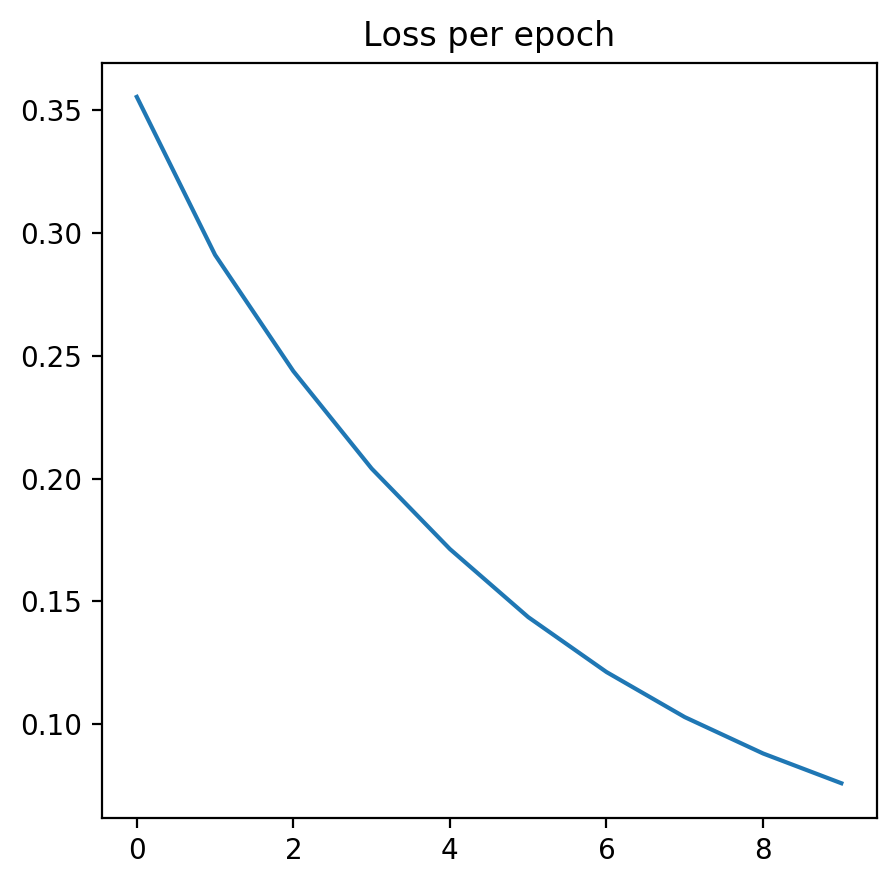

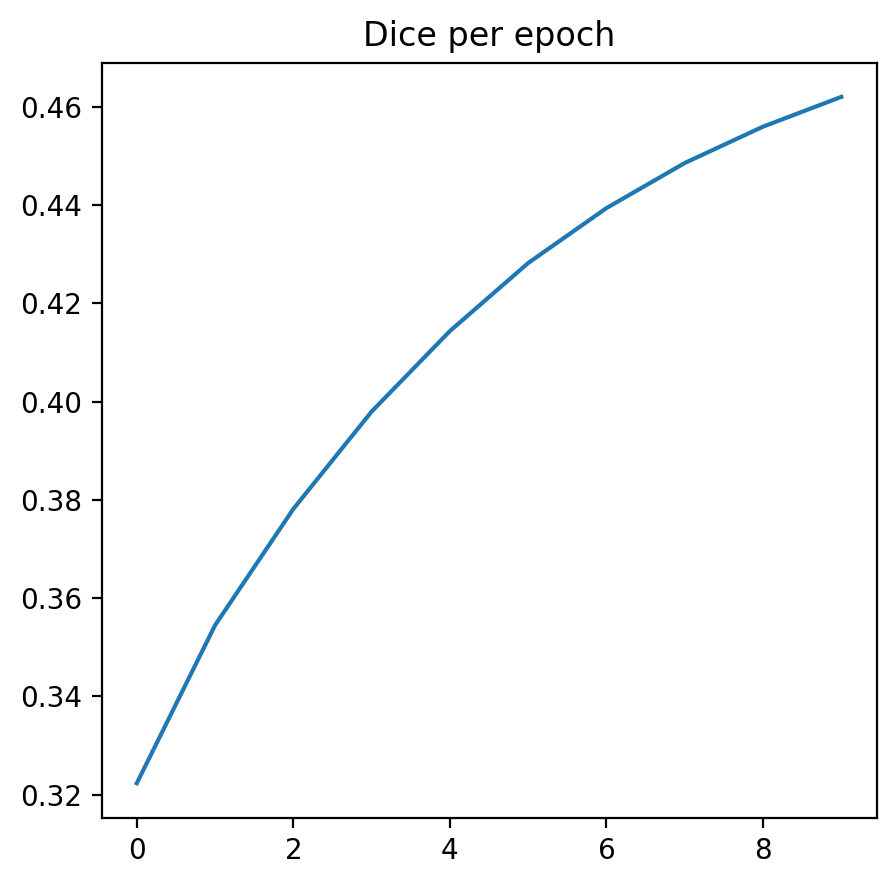

In [114]:
model, loss_dict, dice_dict = train_model(my_model, train_loader, dice_loss, optimizer, 10)


In [124]:
torch.save(model.state_dict(), '/scratch/ht1162/DLSP20Dataset/vpn_model_v2_2.pth')
torch.save(resnet_encoder.state_dict(), '/scratch/ht1162/DLSP20Dataset/resnet_encoder_v2.pth')
torch.save(decoder.state_dict(), '/scratch/ht1162/DLSP20Dataset/vpn_decoder_v2.pth')
torch.save(optimizer.state_dict(), '/scratch/ht1162/DLSP20Dataset/vpn_optimizer.pth')

Epoch 1/40
----------
current epoch train dice loss is 930.372666
current epoch train dice coef is 920.812927
training 1 epoch takes 349.444577
current epoch val dice loss is 196.717042
current epoch val dice coef is 153.641434
valing 1 epoch takes 406.391399
current ts is 0.446835
saving best model
printing test image


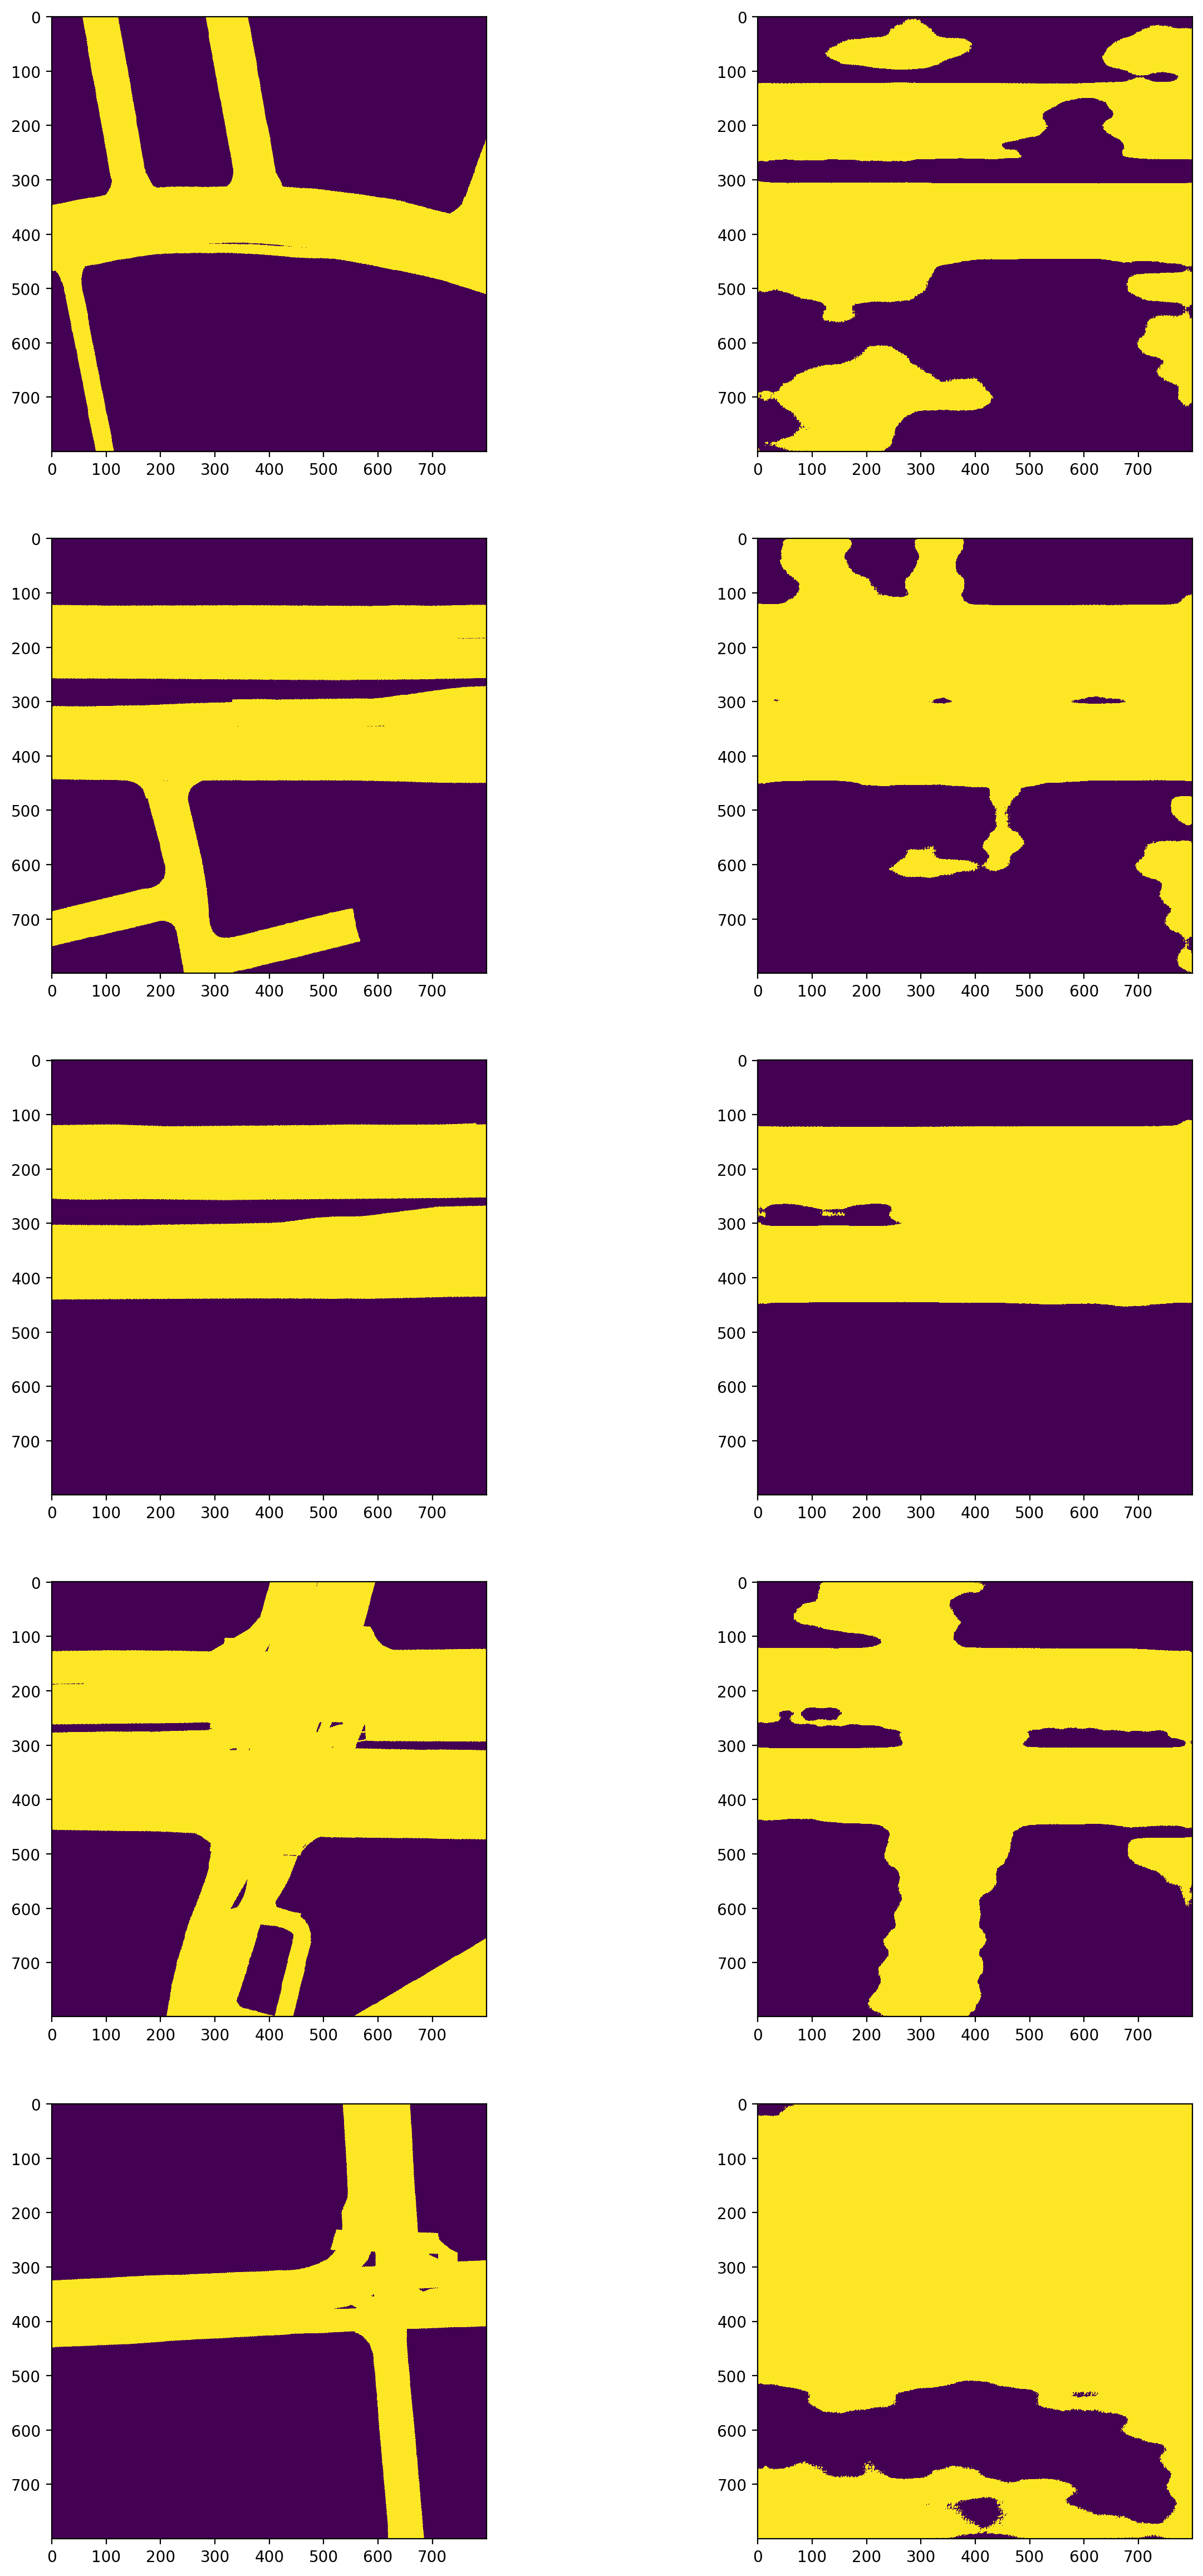

Epoch 2/40
----------
current epoch train dice loss is 747.337984
current epoch train dice coef is 1012.330750
training 1 epoch takes 343.848104
current epoch val dice loss is 187.106755
current epoch val dice coef is 158.446533
valing 1 epoch takes 397.094384
current ts is 0.471364
saving best model
Epoch 3/40
----------
current epoch train dice loss is 619.863170
current epoch train dice coef is 1076.068726
training 1 epoch takes 345.950873
current epoch val dice loss is 166.418869
current epoch val dice coef is 168.790604
valing 1 epoch takes 396.556705
current ts is 0.514149
saving best model
Epoch 4/40
----------
current epoch train dice loss is 516.558369
current epoch train dice coef is 1127.720337
training 1 epoch takes 345.065859
current epoch val dice loss is 145.285499
current epoch val dice coef is 179.357193
valing 1 epoch takes 398.303305
current ts is 0.565794
saving best model
Epoch 5/40
----------
current epoch train dice loss is 430.935295
current epoch train dice coe

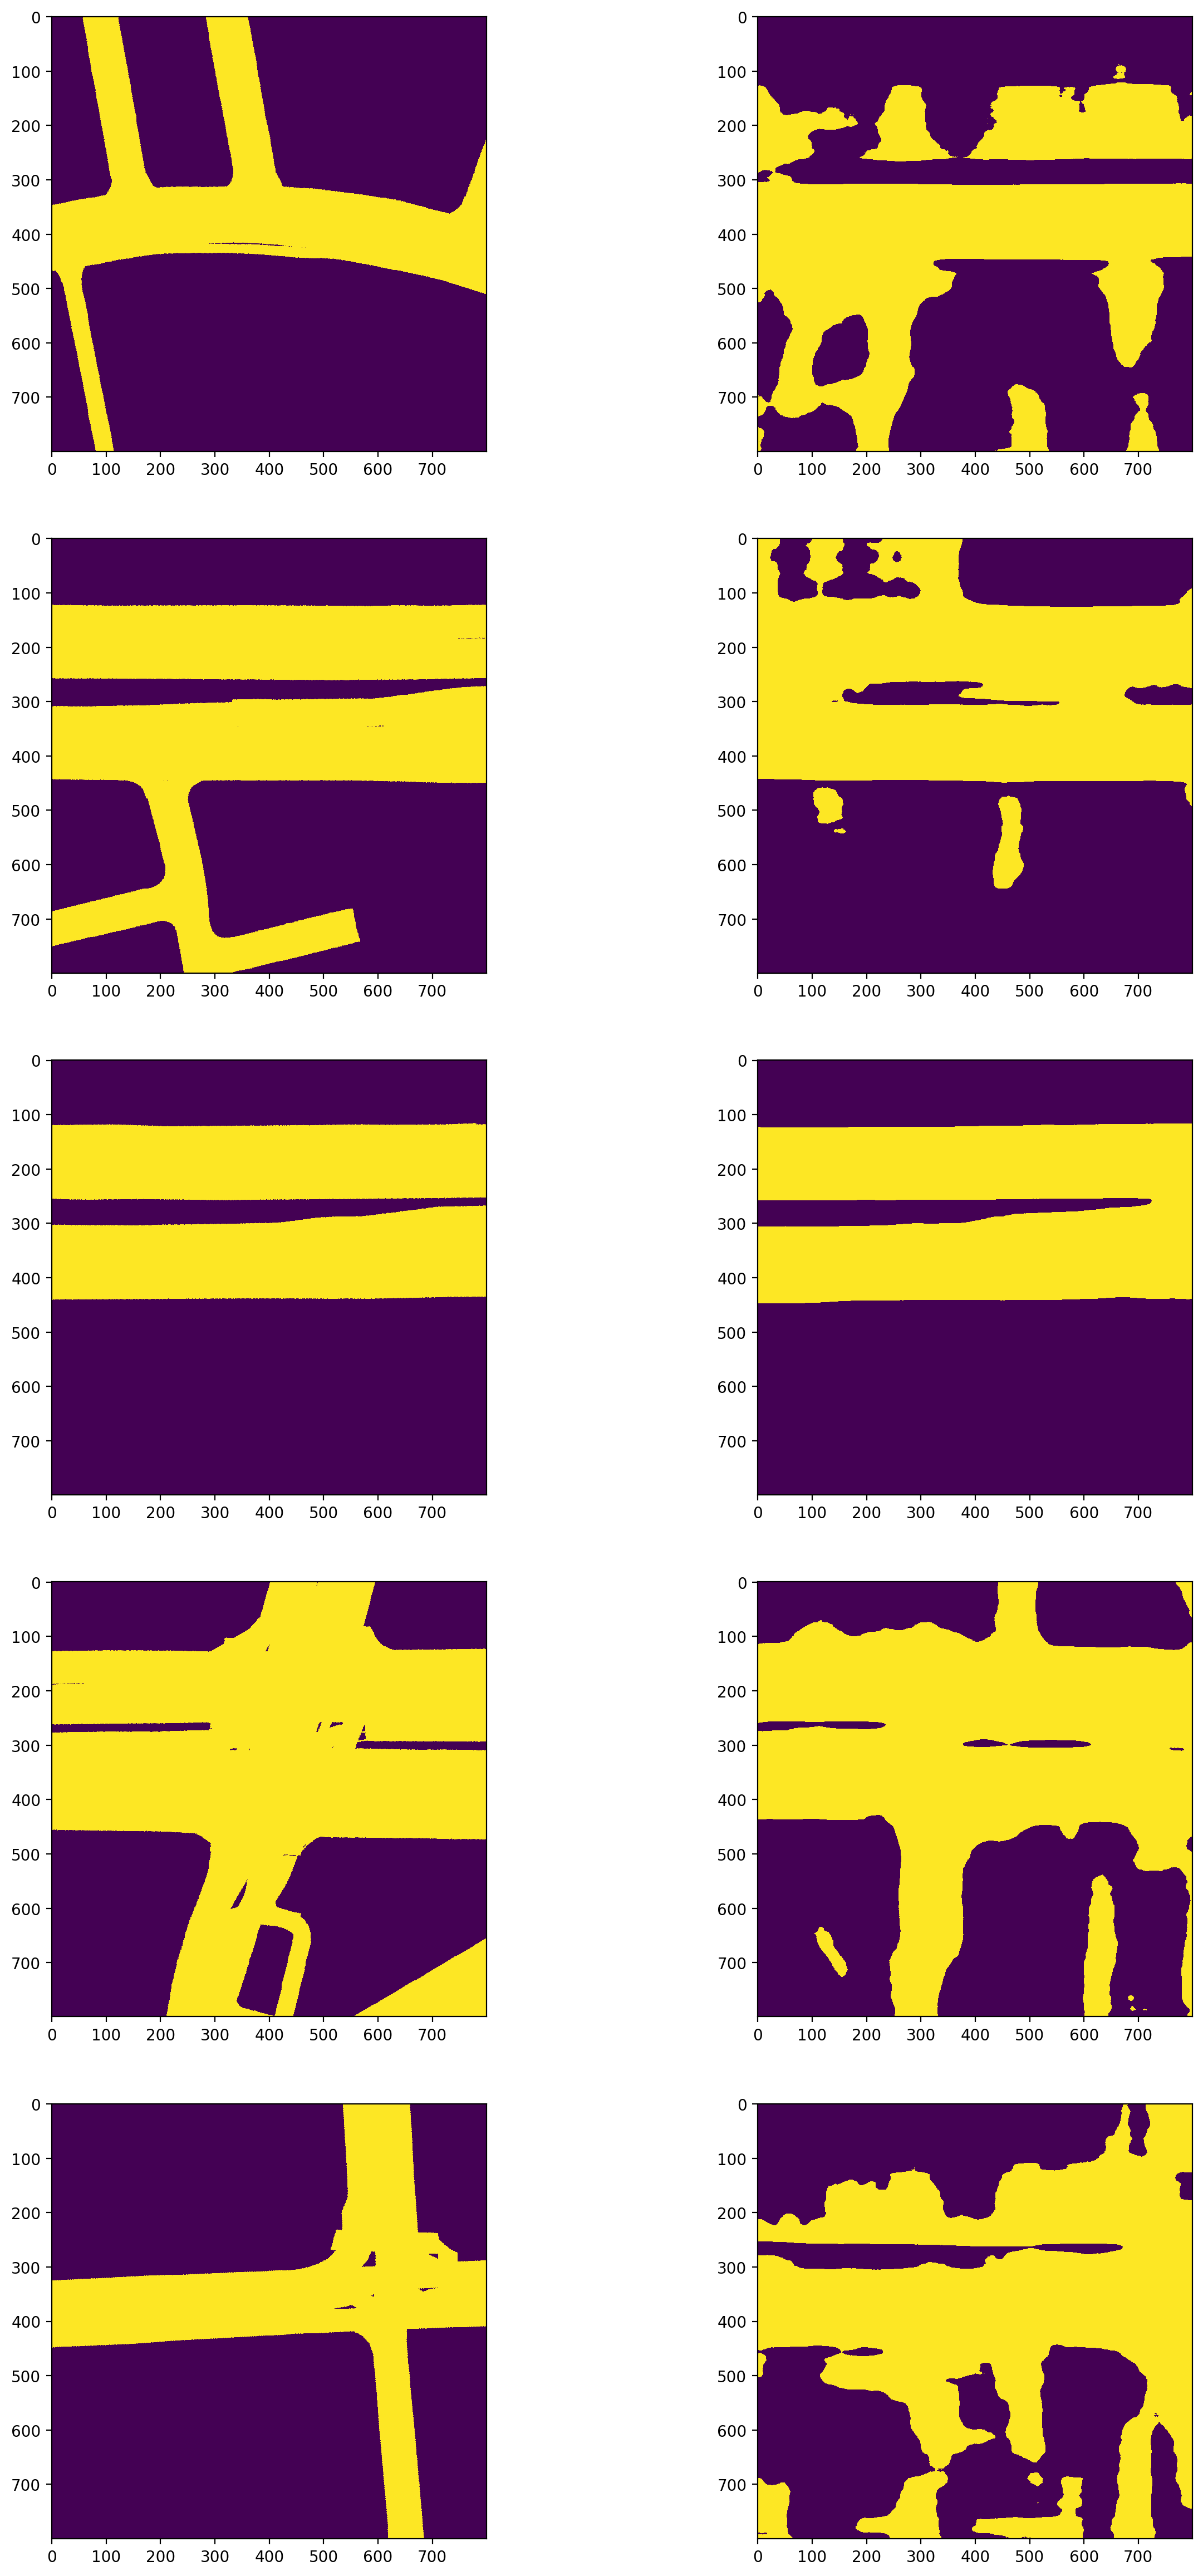

Epoch 12/40
----------
current epoch train dice loss is 139.694544
current epoch train dice coef is 1316.153931
training 1 epoch takes 351.165490
current epoch val dice loss is 97.940155
current epoch val dice coef is 203.029953
valing 1 epoch takes 403.377889
current ts is 0.696429
saving best model
Epoch 13/40
----------
current epoch train dice loss is 122.127243
current epoch train dice coef is 1324.937134
training 1 epoch takes 358.628174
current epoch val dice loss is 98.053982
current epoch val dice coef is 202.973007
valing 1 epoch takes 413.042329
current ts is 0.700523
Epoch 14/40
----------
current epoch train dice loss is 108.387303
current epoch train dice coef is 1331.803955
training 1 epoch takes 358.011501
current epoch val dice loss is 98.234120
current epoch val dice coef is 202.882950
valing 1 epoch takes 412.888033
current ts is 0.698641
Epoch 15/40
----------
current epoch train dice loss is 96.783255
current epoch train dice coef is 1337.608521
training 1 epoch ta

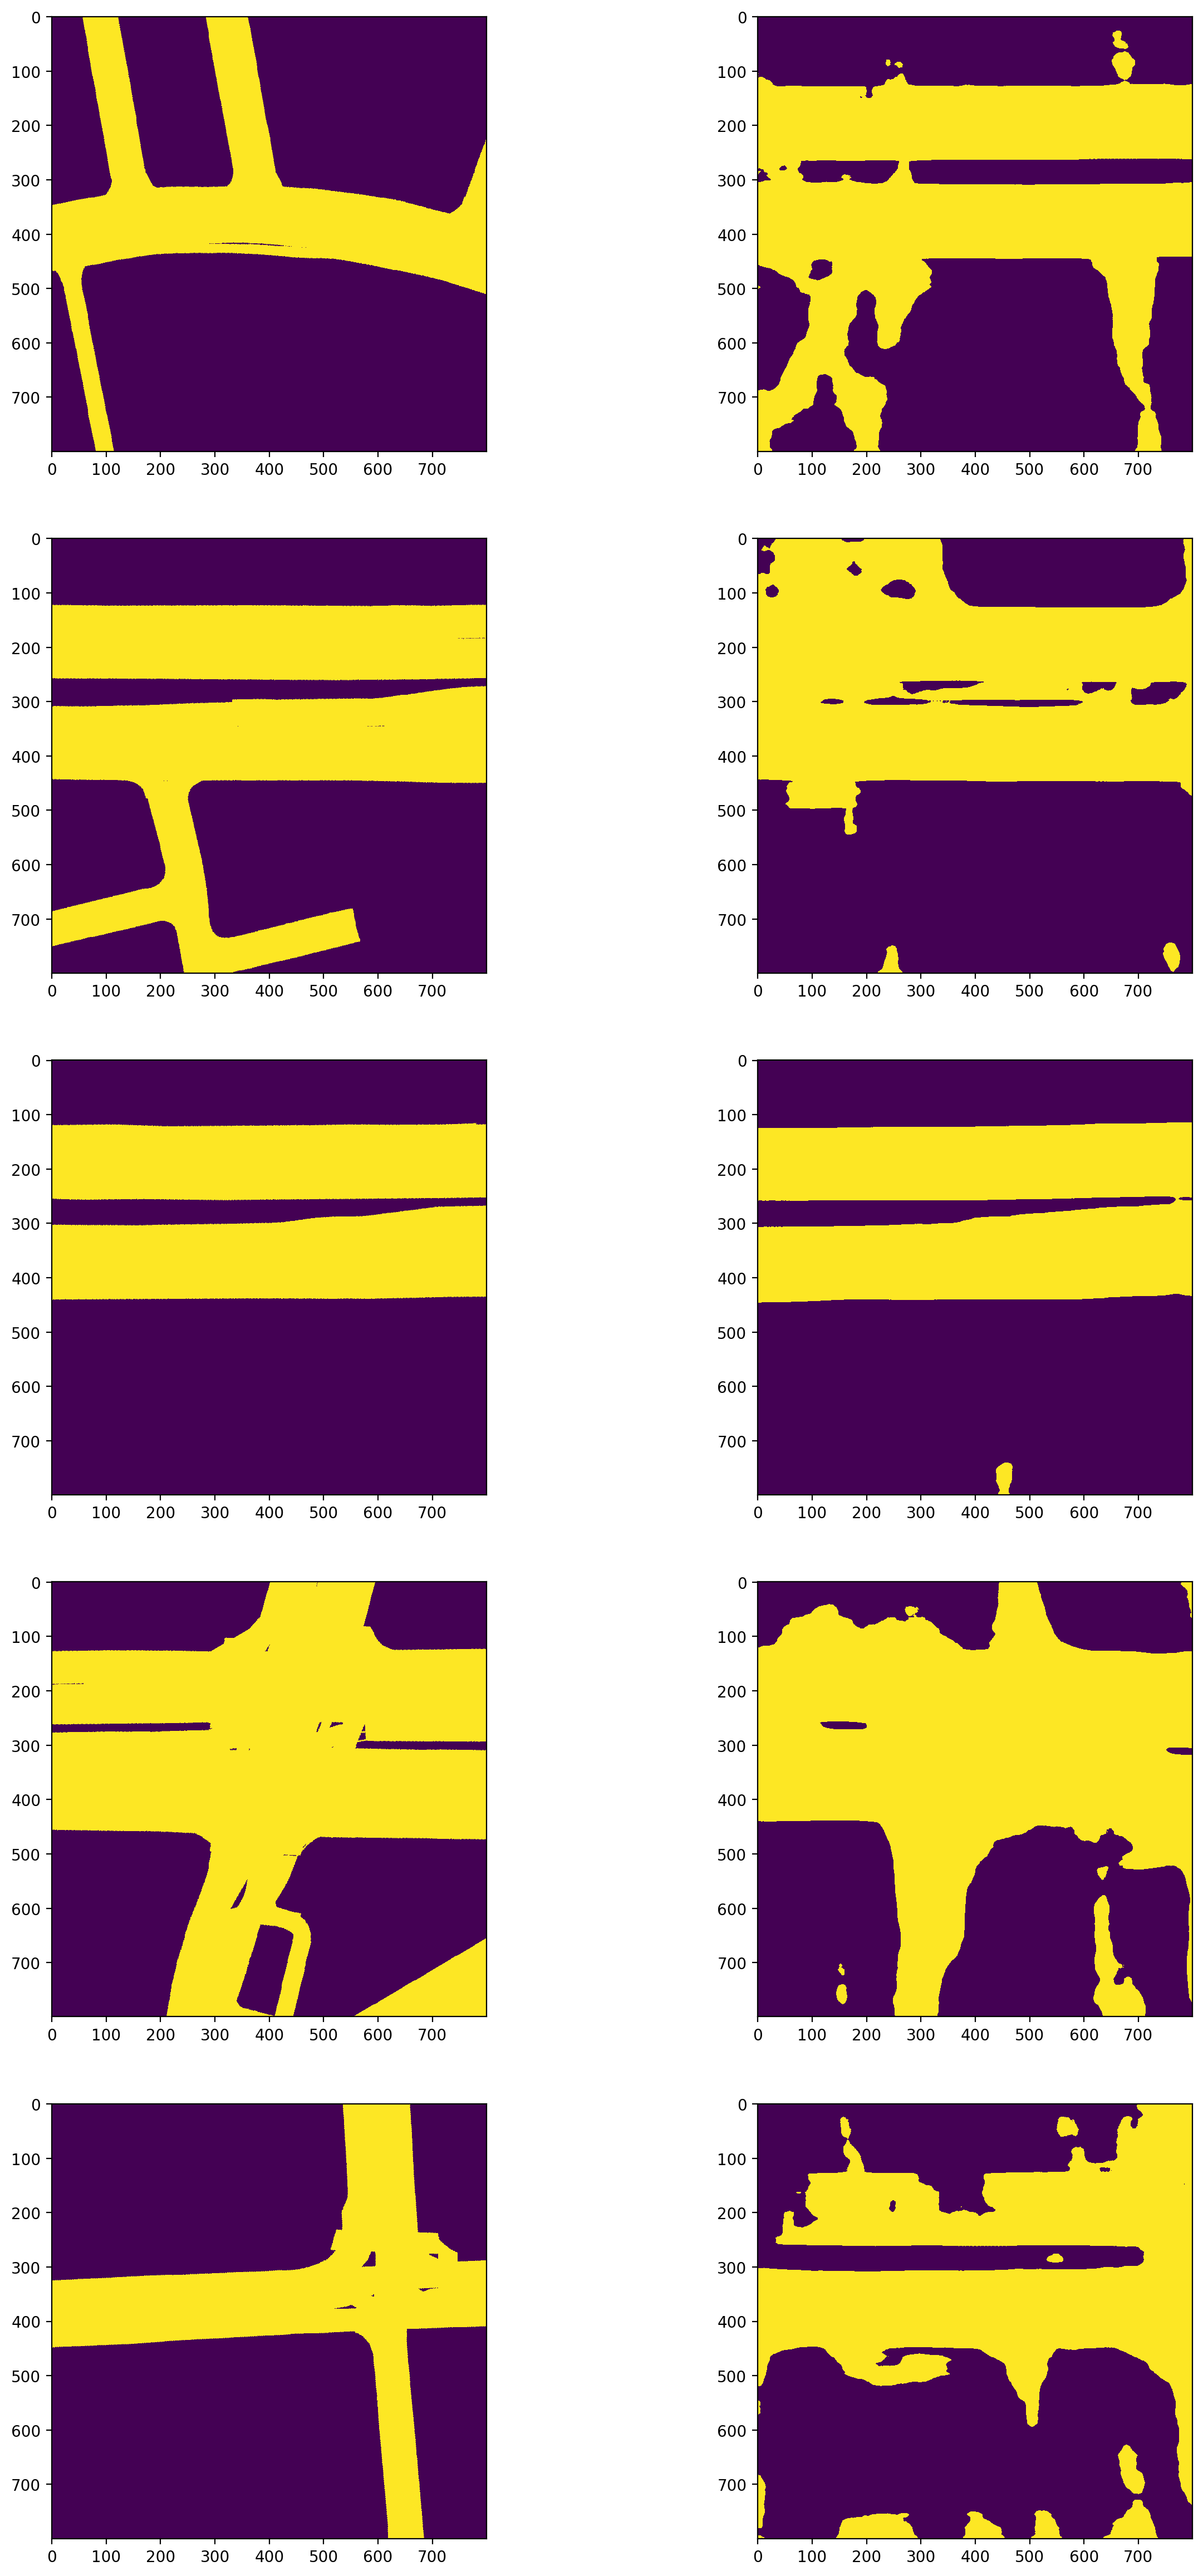

Epoch 22/40
----------
current epoch train dice loss is 57.177252
current epoch train dice coef is 1357.410767
training 1 epoch takes 356.609623
current epoch val dice loss is 84.096479
current epoch val dice coef is 209.951706
valing 1 epoch takes 409.247147
current ts is 0.741136
Epoch 23/40
----------
current epoch train dice loss is 54.407430
current epoch train dice coef is 1358.796387
training 1 epoch takes 350.146827
current epoch val dice loss is 95.207982
current epoch val dice coef is 204.396011
valing 1 epoch takes 399.580025
current ts is 0.711550
Epoch 24/40
----------
current epoch train dice loss is 52.125831
current epoch train dice coef is 1359.939209
training 1 epoch takes 349.665308
current epoch val dice loss is 88.724729
current epoch val dice coef is 207.637558
valing 1 epoch takes 399.766169
current ts is 0.729556
Epoch 25/40
----------
current epoch train dice loss is 50.034447
current epoch train dice coef is 1360.983154
training 1 epoch takes 349.120232
curren

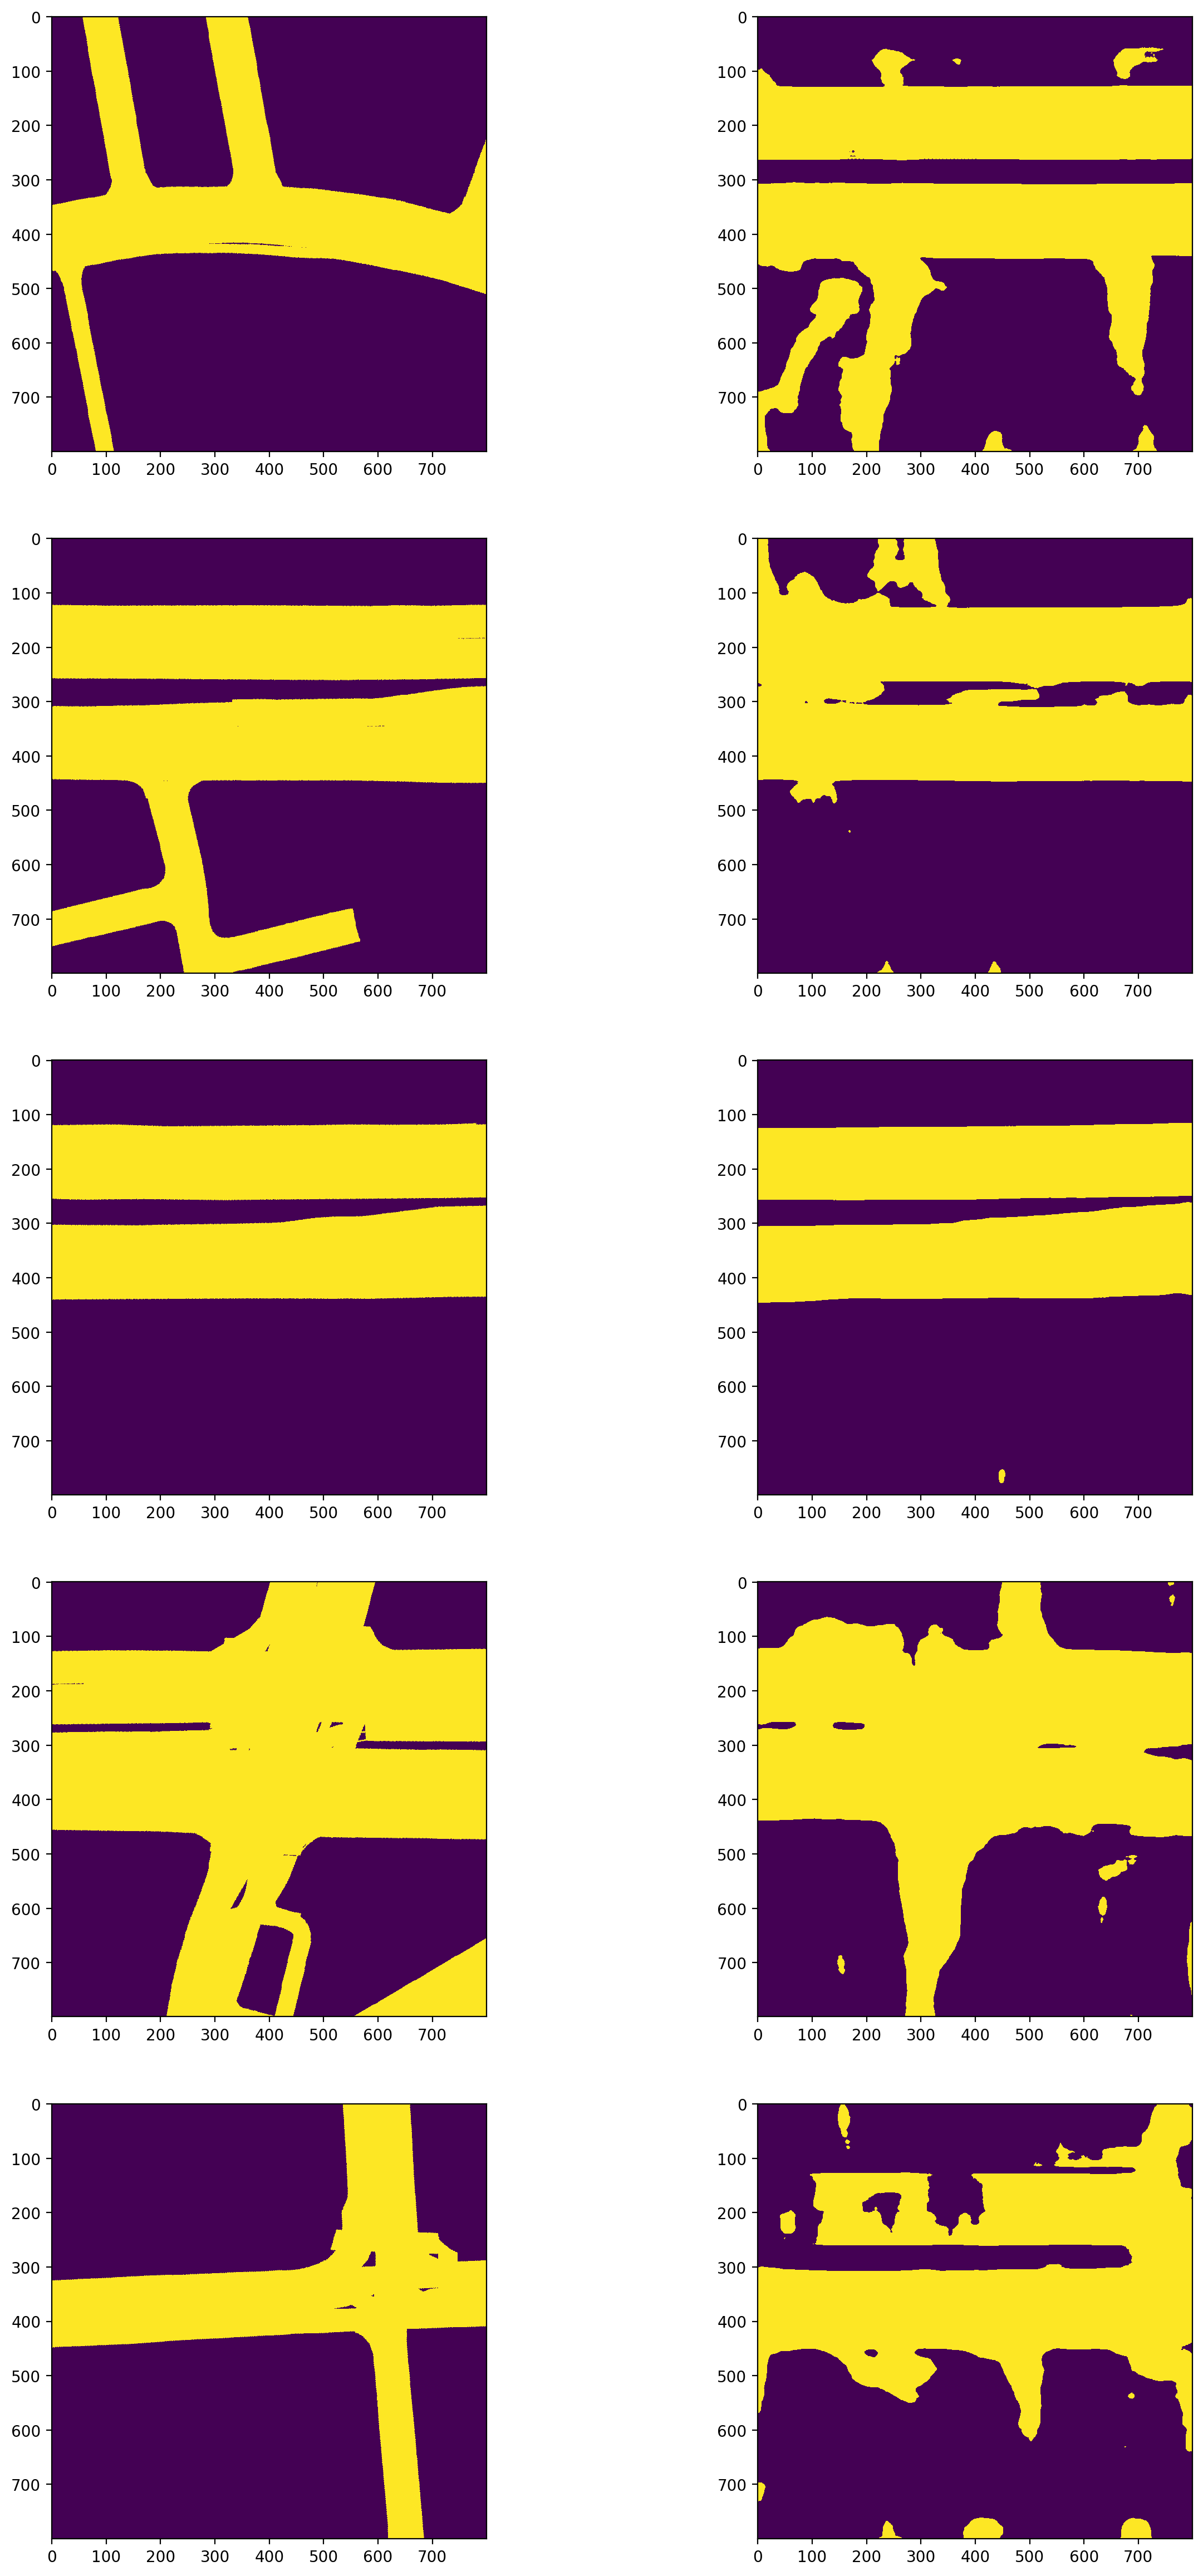

Epoch 32/40
----------
current epoch train dice loss is 41.192956
current epoch train dice coef is 1365.403076
training 1 epoch takes 352.280547
current epoch val dice loss is 80.373882
current epoch val dice coef is 211.813095
valing 1 epoch takes 403.036660
current ts is 0.747655
Epoch 33/40
----------
current epoch train dice loss is 40.640183
current epoch train dice coef is 1365.681396
training 1 epoch takes 353.183497
current epoch val dice loss is 79.155547
current epoch val dice coef is 212.422226
valing 1 epoch takes 404.068567
current ts is 0.754604
saving best model
Epoch 34/40
----------
current epoch train dice loss is 39.683095
current epoch train dice coef is 1366.159302
training 1 epoch takes 353.072839
current epoch val dice loss is 83.338249
current epoch val dice coef is 210.330811
valing 1 epoch takes 404.143867
current ts is 0.739080
Epoch 35/40
----------
current epoch train dice loss is 38.914043
current epoch train dice coef is 1366.543335
training 1 epoch takes

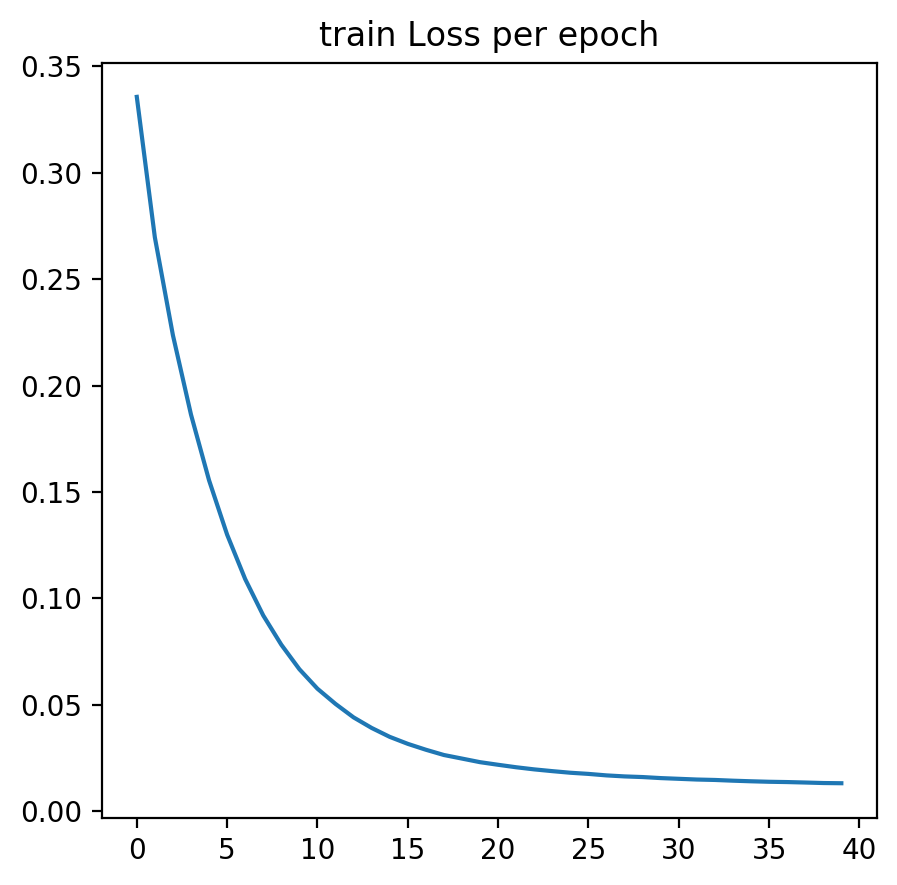

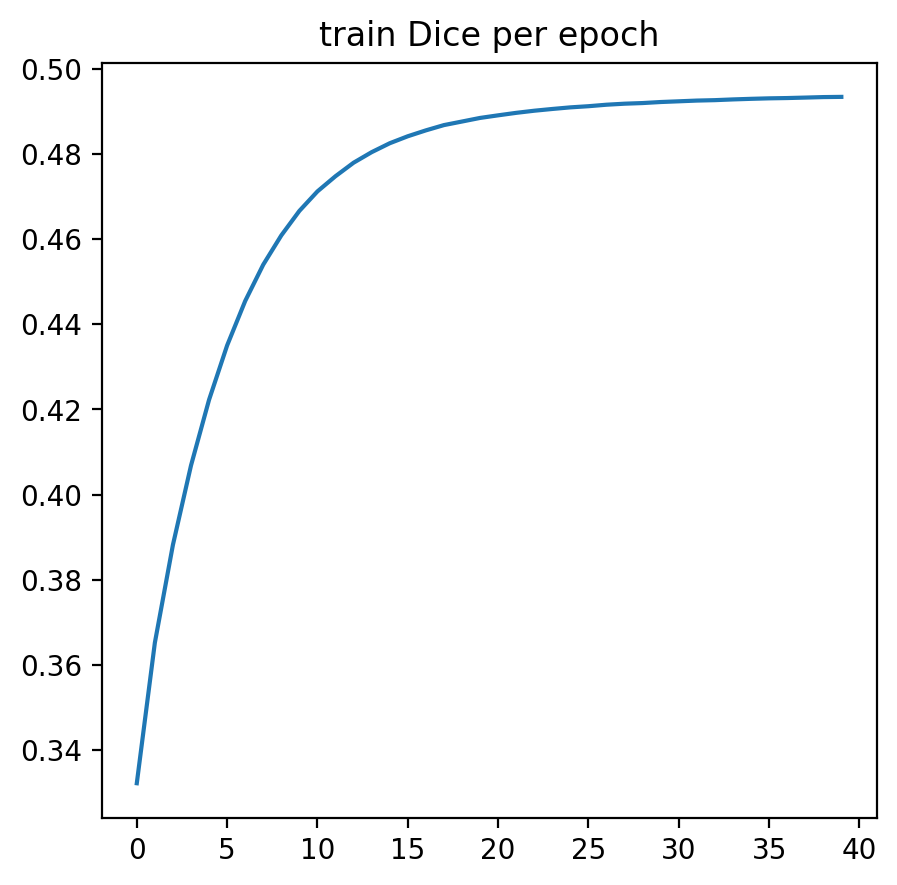

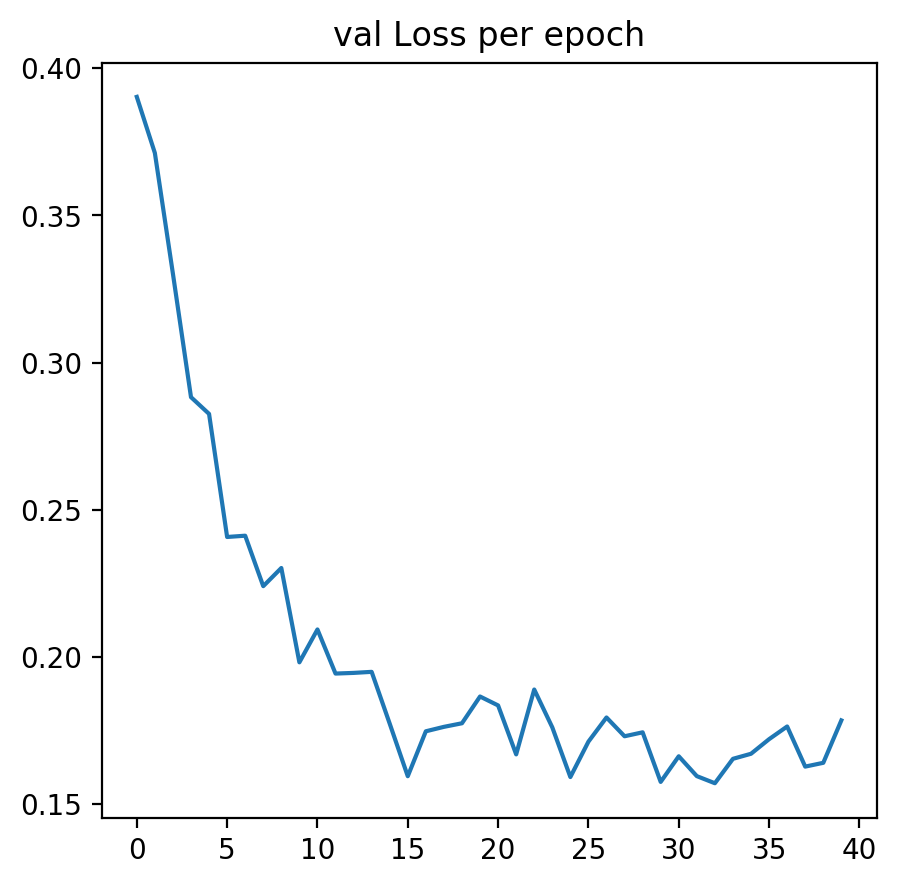

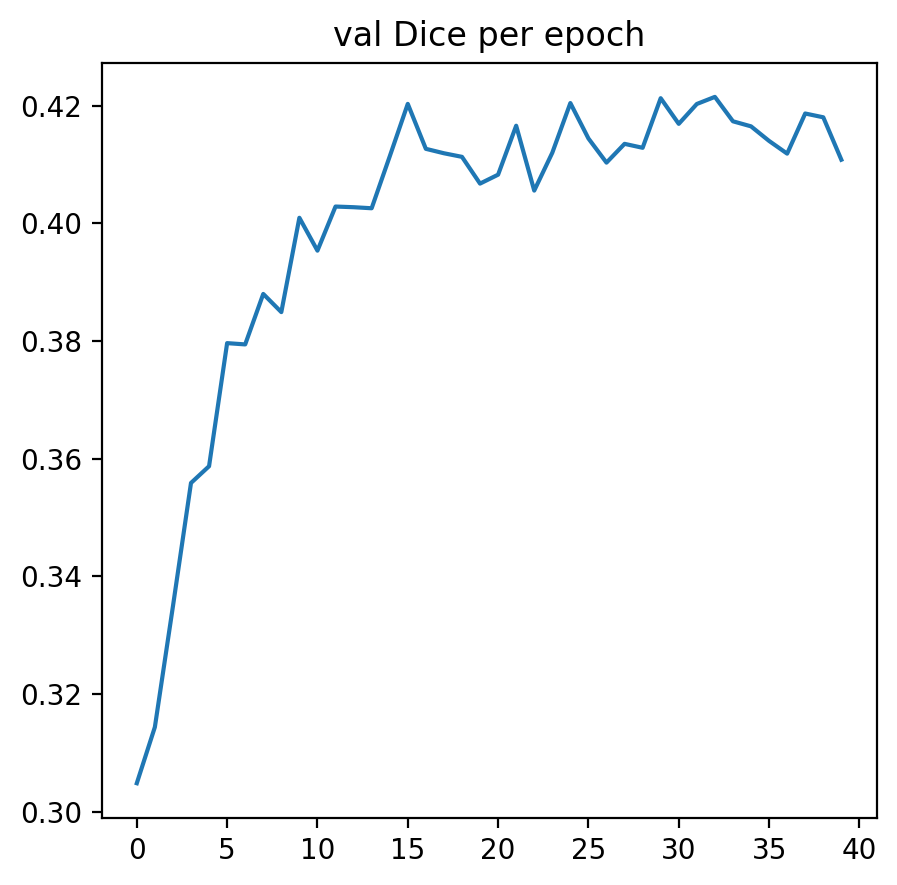

In [21]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder1 = torchvision.models.resnet18(pretrained = False)
resnet_encoder1 = list(resnet_encoder1.children())[:-3]
resnet_encoder1 = nn.Sequential(*resnet_encoder1)
for param in resnet_encoder1.parameters():
    param.requires_grad = True
resnet_encoder1 = resnet_encoder1.to(device)

DIM1 = 16
DIM2 = 20
decoder1 = PPMBilinear(fc_dim=256).to(device)
my_model1 = vpn_model(DIM1, DIM2, resnet_encoder1, decoder1).to(device)
optimizer1 = torch.optim.Adam(my_model1.parameters(), lr = 1e-4)

model1, loss_dict1, dice_dict1, ts_loss1, best_model_wts1 = train_eval_model(my_model1, 
                                                                 dataloaders, 
                                                                 dice_loss, 
                                                                 optimizer1, 
                                                                 num_epochs=40,
                                                                 print_every=10,
                                                                 eval_every=1,
                                                                 to_eval=True)

In [23]:
pickle.dump( loss_dict1, open( "/scratch/ht1162/DLSP20Dataset/loss_dict1.p", "wb" ) )
pickle.dump(dice_dict1, open('/scratch/ht1162/DLSP20Dataset/dice_dict1.p', 'wb'))
pickle.dump(ts_loss1, open('/scratch/ht1162/DLSP20Dataset/ts_loss1.p', 'wb'))

In [27]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
test_encoder = torchvision.models.resnet18(pretrained = False)
test_encoder = list(test_encoder.children())[:-3]
test_encoder = nn.Sequential(*test_encoder)

test_encoder = test_encoder.to(device)

test_decoder = PPMBilinear(fc_dim=256).to(device)
test_model = vpn_model(DIM1, DIM2, test_encoder, test_decoder).to(device)
test_model.load_state_dict(best_model_wts1)


In [35]:
test_model.load_state_dict(torch.load('/scratch/ht1162/DLSP20Dataset/vpn_model_v3.pth'))

<All keys matched successfully>

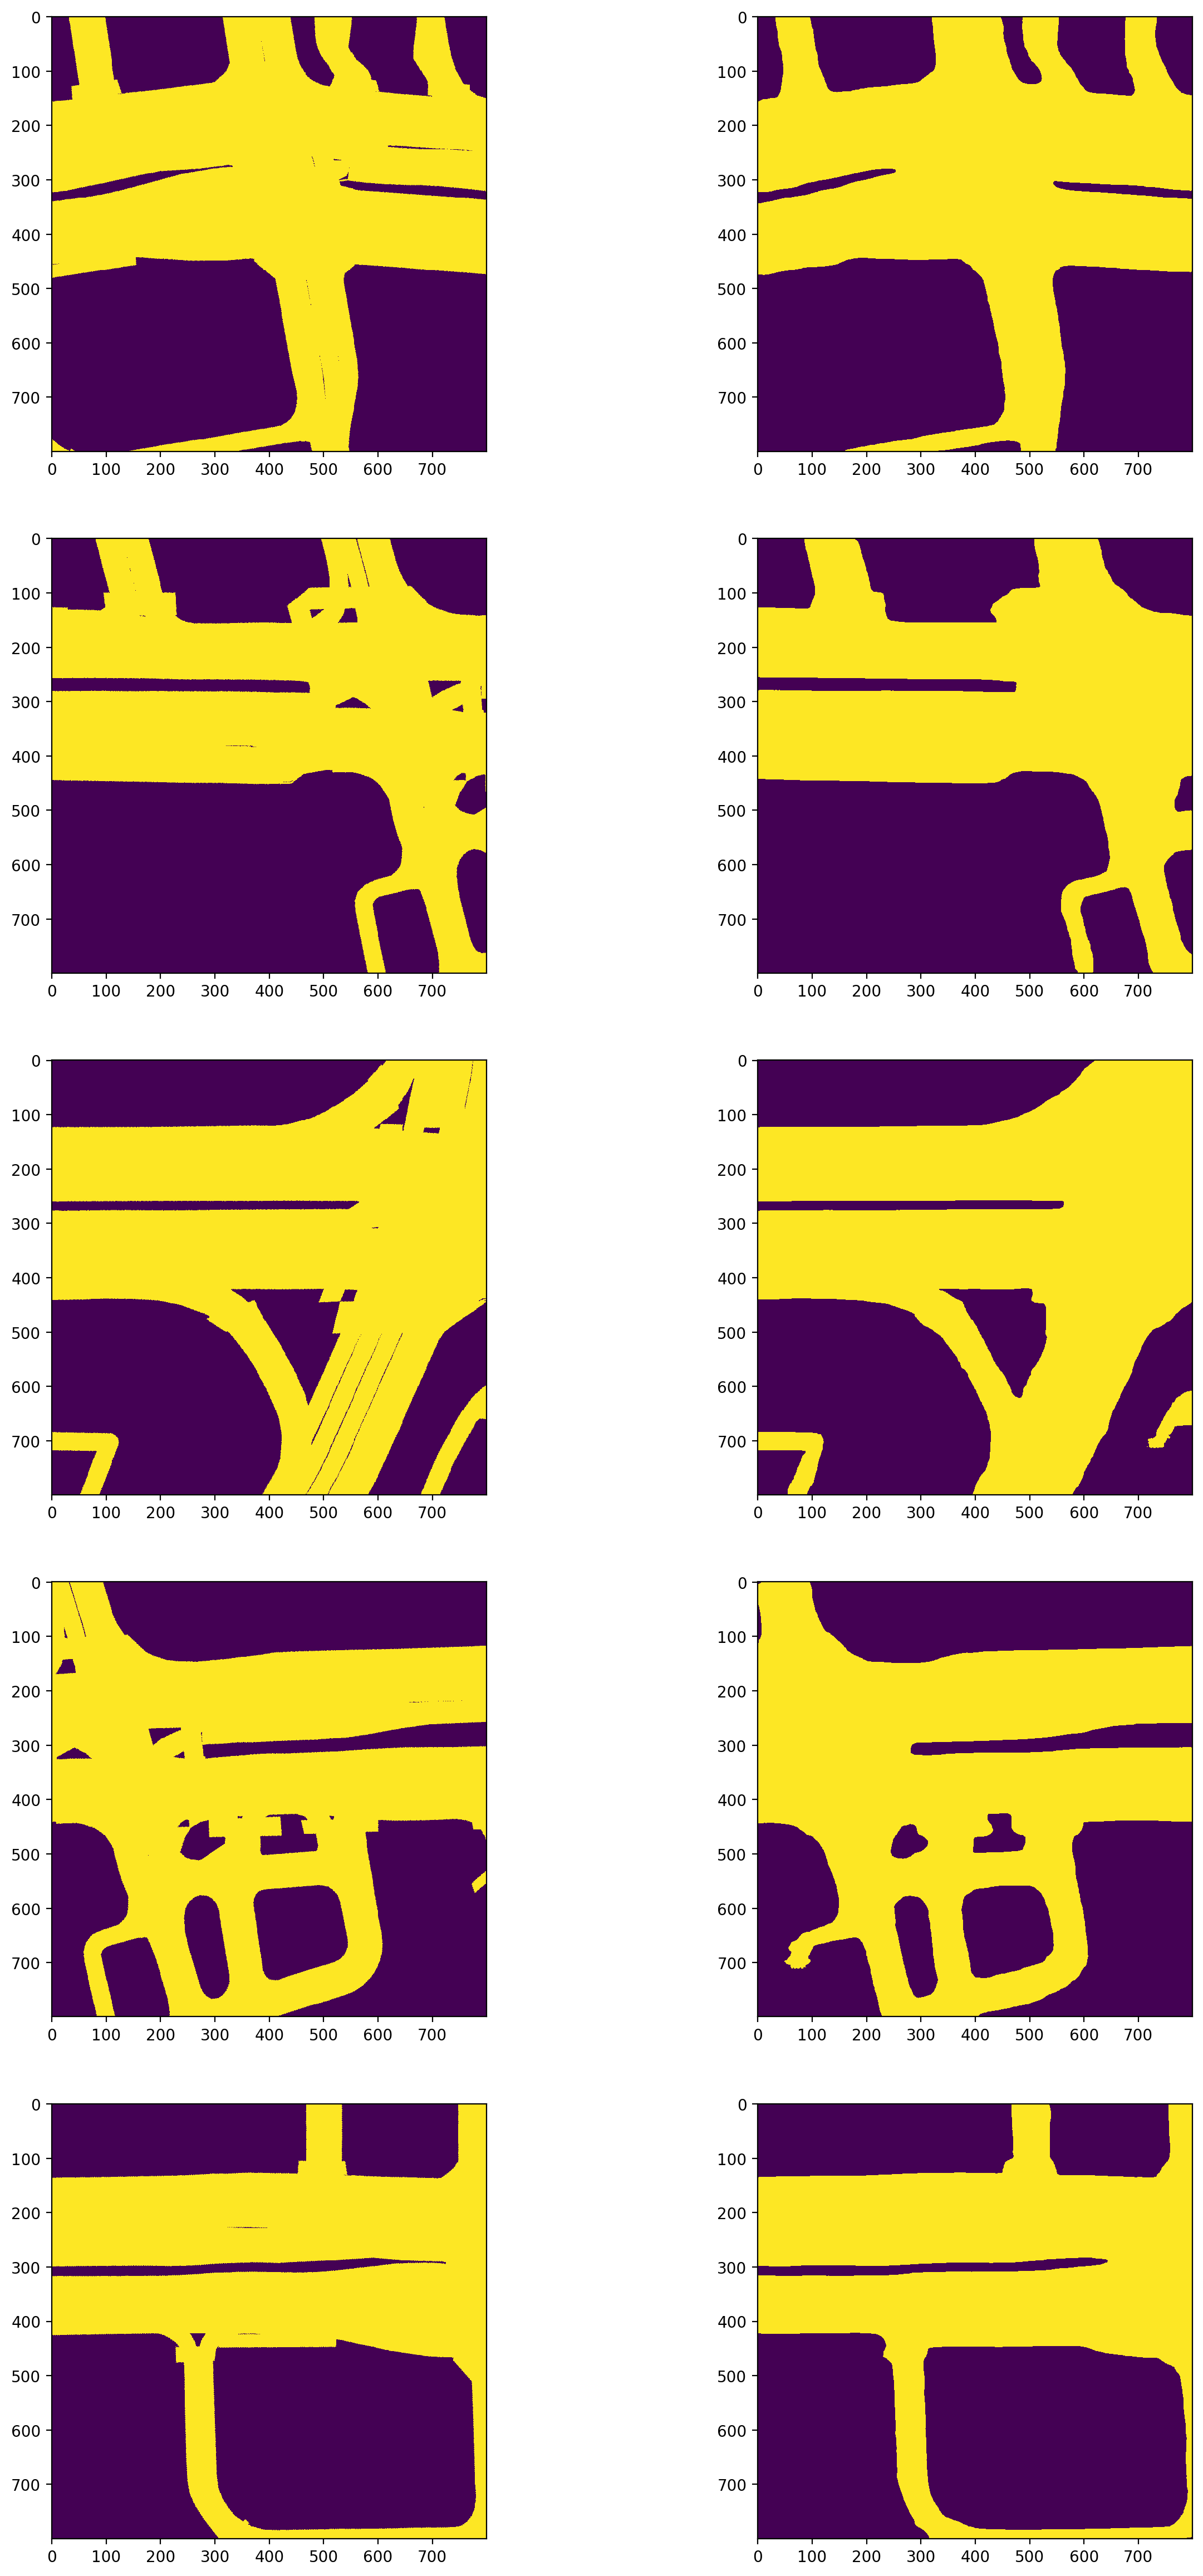

In [36]:
# test on training data

fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [123, 292, 419, 322, 44]
for fig_i, i in enumerate(test_idx):
    inputs = train_set[i][0].unsqueeze(0).to(device)

    outputs = test_model(inputs).cpu().squeeze().detach()

    ax[fig_i, 0].imshow(train_set[i][2].cpu().numpy())

    ax[fig_i, 1].imshow((outputs>0.5).numpy())

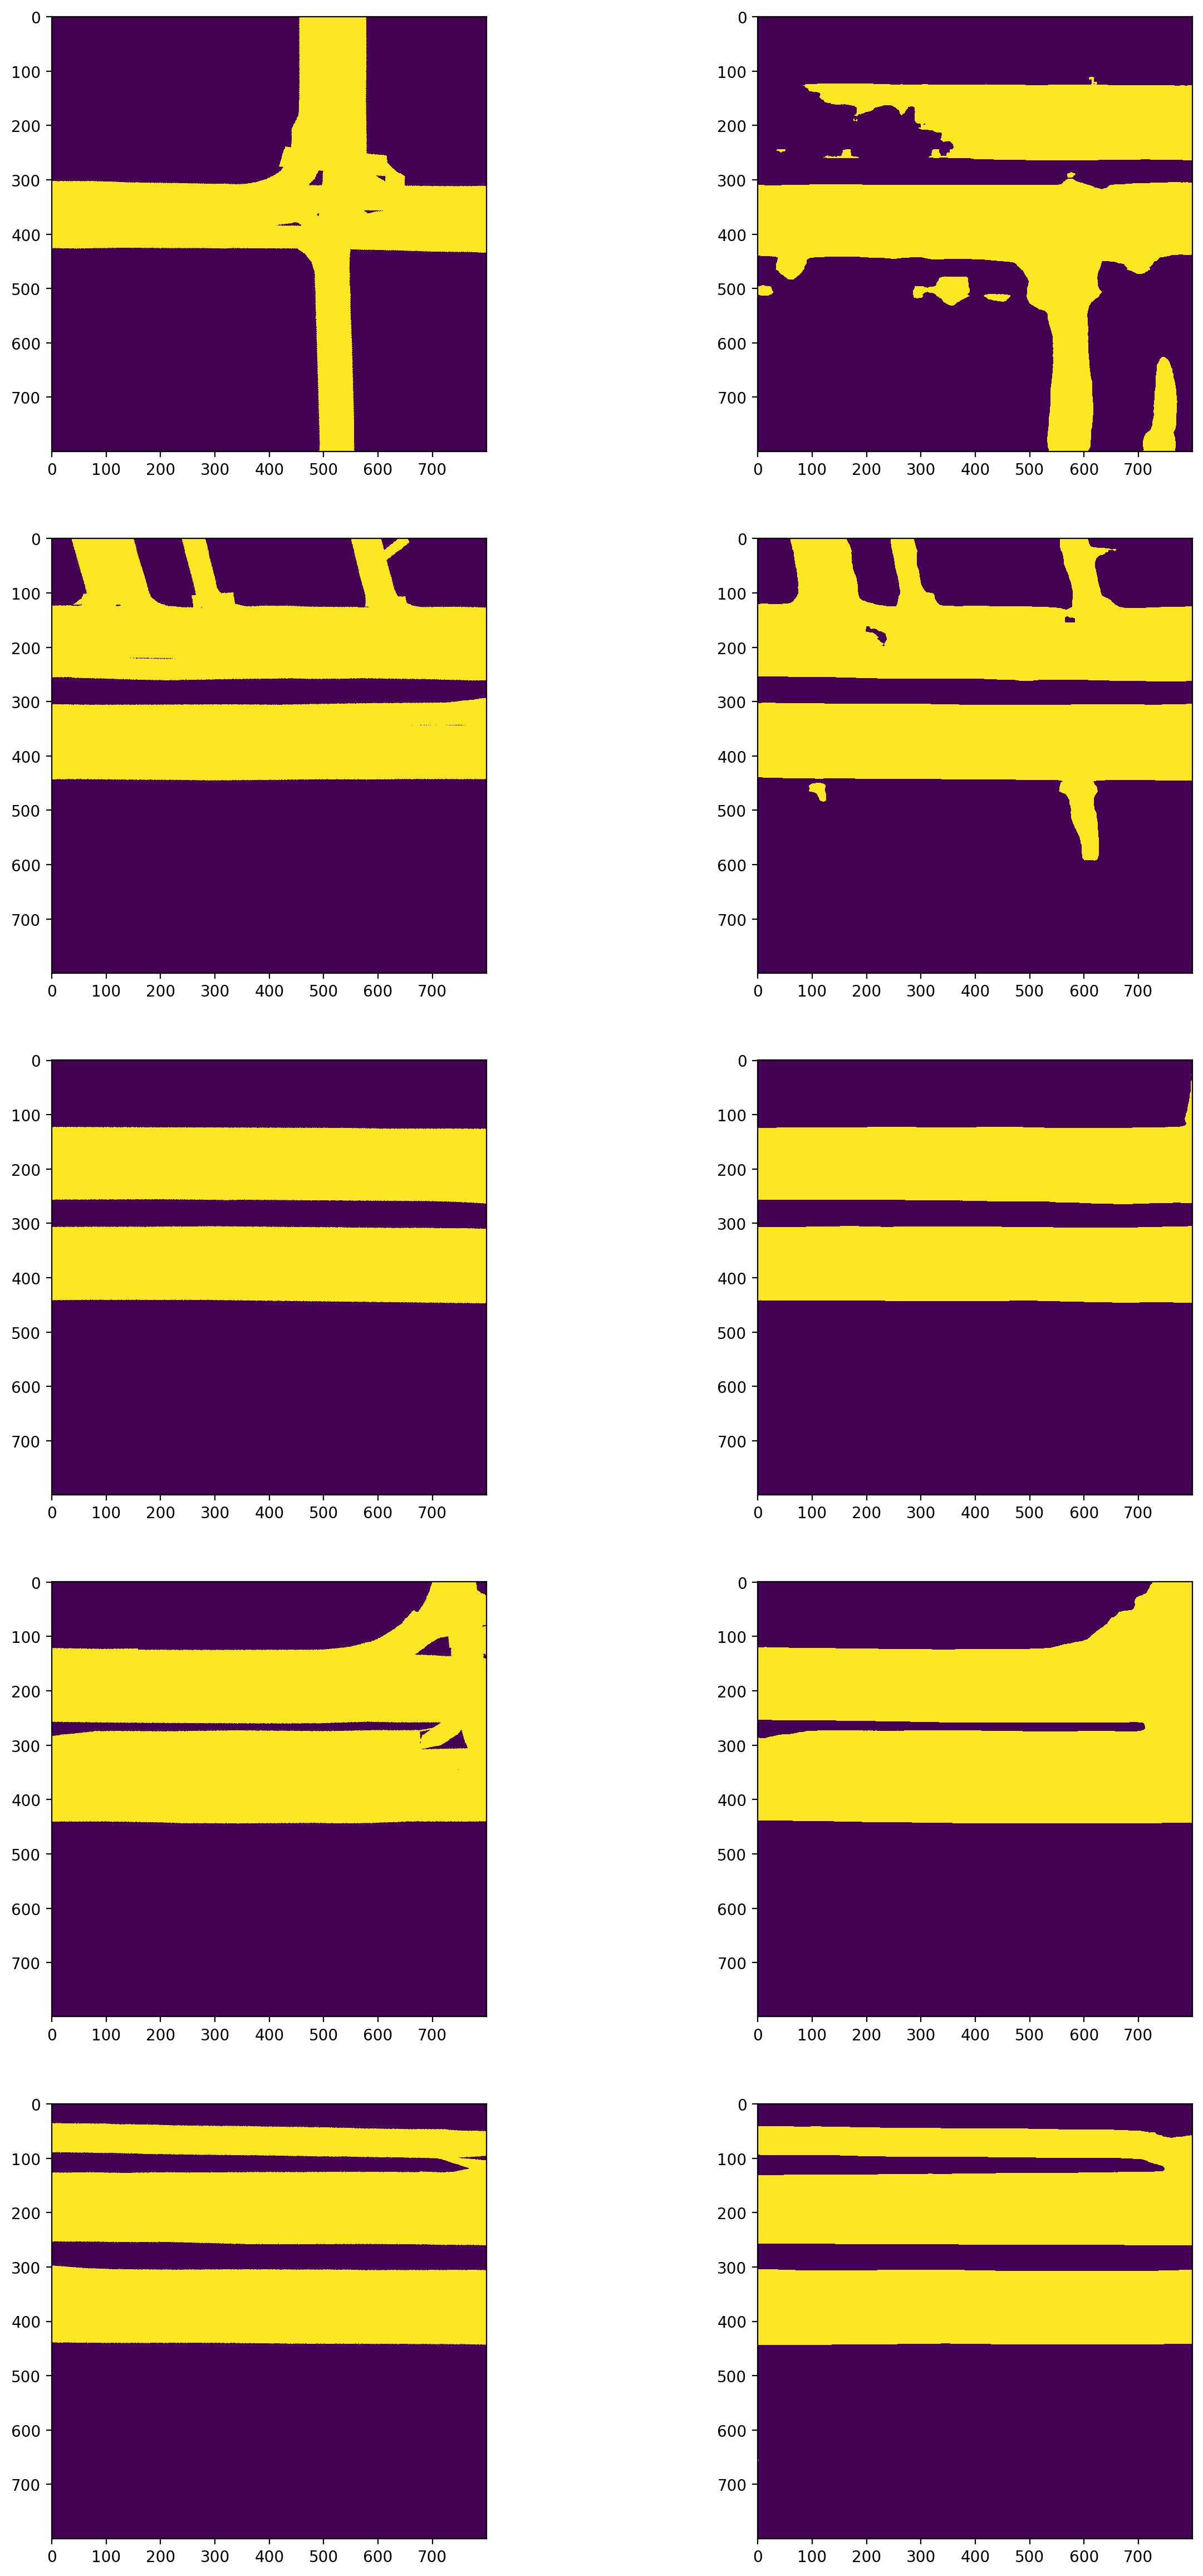

In [37]:
# test on best model performance on validation dataset
fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [56,184,391,444, 500]
for fig_i, i in enumerate(test_idx):
    inputs = val_set[i][0].unsqueeze(0).to(device)

    outputs = test_model(inputs).cpu().squeeze().detach()

    ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

    ax[fig_i, 1].imshow((outputs>0.5).numpy())

In [5]:
from VPN_model import PPMBilinear, vpn_model

In [6]:
resnet_encoder = torchvision.models.resnet18(pretrained = False)
resnet_encoder = list(resnet_encoder.children())[:-3]
resnet_encoder = nn.Sequential(*resnet_encoder)

resnet_encoder = resnet_encoder

DIM1 = 16
DIM2 = 20
decoder = PPMBilinear(fc_dim=256)

my_model = vpn_model(DIM1, DIM2, resnet_encoder, decoder)